In [15]:
import sys 
print(sys.version)

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [16]:
import os
import copy
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
#from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from bertModel import BertClassification, dense_opt
from datasets import text_dataset, financialPhraseBankDataset
import argparse
from sklearn.metrics import f1_score

In [17]:
labels = {0:'neutral', 1:'positive',2:'negative'}
num_labels= len(labels)
vocab ="finance-uncased"
vocab_path = '/Users/svetlana/Downloads/analyst_tone-2/vocab' 
pretrained_weights_path ='/Users/svetlana/Downloads/analyst_tone-2/pretrained_weights'
fine_tuned_weight_path = '/Users/svetlana/Downloads/analyst_tone-2/fine_tuned.pth'   
max_seq_length = 512
device=torch.device("cpu")

In [18]:
model = BertClassification(weight_path = pretrained_weights_path, 
                           num_labels=num_labels, vocab=vocab)

In [19]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
bert.embeddings.word_embeddings.weight 	 torch.Size([30873, 768])
bert.embeddings.position_embeddings.weight 	 torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([2, 768])
bert.embeddings.LayerNorm.weight 	 torch.Size([768])
bert.embeddings.LayerNorm.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.weight 	 torch.Size([768])
bert.encoder.layer.0.attention.outp

bert.encoder.layer.8.output.LayerNorm.weight 	 torch.Size([768])
bert.encoder.layer.8.output.LayerNorm.bias 	 torch.Size([768])
bert.encoder.layer.9.attention.self.query.weight 	 torch.Size([768, 768])
bert.encoder.layer.9.attention.self.query.bias 	 torch.Size([768])
bert.encoder.layer.9.attention.self.key.weight 	 torch.Size([768, 768])
bert.encoder.layer.9.attention.self.key.bias 	 torch.Size([768])
bert.encoder.layer.9.attention.self.value.weight 	 torch.Size([768, 768])
bert.encoder.layer.9.attention.self.value.bias 	 torch.Size([768])
bert.encoder.layer.9.attention.output.dense.weight 	 torch.Size([768, 768])
bert.encoder.layer.9.attention.output.dense.bias 	 torch.Size([768])
bert.encoder.layer.9.attention.output.LayerNorm.weight 	 torch.Size([768])
bert.encoder.layer.9.attention.output.LayerNorm.bias 	 torch.Size([768])
bert.encoder.layer.9.intermediate.dense.weight 	 torch.Size([3072, 768])
bert.encoder.layer.9.intermediate.dense.bias 	 torch.Size([3072])
bert.encoder.layer.9.

In [20]:
model.load_state_dict(torch.load(fine_tuned_weight_path, map_location=device))
model.to(device)

BertClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )


# 0 is neutral, 1 is positive, and 2 is negative 

In [21]:
import glob
import csv
import pandas as pd
text_path = '/Users/svetlana/Desktop/Creation/*'
files = glob.glob(text_path)

def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//75 >0:
    n = len(text1.split())//75
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:100]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*75:w*75 + 100]
      l_total.append(" ".join(l_parcial))
  return l_total

In [22]:
sentences = []
length_sent = []
for file in files:
    with open(file) as f:
        sentence = f.read().strip().split('\n')
        length = len(sentence)
        length = np.log(length)
    sentences.append(sentence)
    length_sent.append(length)

In [23]:
sentences

[['EL DORADO, Ark.--(BUSINESS WIRE)--Oct. 10, 2018-- Murphy Oil Corporation (NYSE: MUR) announced today that its wholly owned subsidiary, Murphy Exploration & Production Company - USA, has entered into a definitive agreement to form a new joint venture company with Petrobras America Inc. (“PAI”), a subsidiary of Petrobras (NYSE: PBR). The joint venture company will be comprised of Gulf of Mexico producing assets from Murphy and PAI with Murphy overseeing the operations. The transaction will have an effective date of October 1, 2018 and is expected to close by year-end 2018. ',
  'Both companies will contribute all their current producing Gulf of Mexico assets to the joint venture, which will be owned 80 percent by Murphy and 20 percent by PAI. The transaction excludes exploration blocks from both companies, with the exception of PAI’s blocks that hold deep exploration rights. Murphy will pay cash consideration of $900 million to PAI, subject to normal closing adjustments. Additionally,

In [24]:
import transformers
from transformers import BertTokenizer
tokenizer = BertTokenizer(vocab_file = vocab_path, do_lower_case = True, 
                          do_basic_tokenize = True)
from torch import Tensor

In [25]:
def sentiment_function(sentences):
    for sent in sentences:
        encoded_data = tokenizer.batch_encode_plus(
            sentences, add_special_tokens = True,
            return_attention_mask = True,
            max_length = max_seq_length,
            pad_to_max_length = True,
            return_tensors = 'pt')
        
    labels = torch.empty(len(sentences), dtype=torch.long)
    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']
    labels = torch.tensor(labels)
    
    dataset = TensorDataset(input_ids, attention_masks, labels)
    
    batch_size = 32
    
    dataloader = DataLoader(
        dataset, 
        sampler = SequentialSampler(dataset),
        batch_size=batch_size)
    
    def predict(dataloader_):
        model.eval()
        predictions = []
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2],
                     }
            with torch.no_grad():
                outputs = model(**inputs)
        
            outputs = F.softmax(outputs,dim=1)
            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
        
            predictions.append(outputs)
        
        predictions = np.concatenate(predictions, axis = 0)
    
        return predictions
    
    pred = predict(dataloader_ = dataloader)
    
    positives = 0
    negatives = 0
    neutrals = 0
    sentiment = []
    for i in range(len(pred)):
        pred_labels_i = np.argmax(pred[i]).flatten()
        sentiment.append(pred_labels_i[0])
        if pred_labels_i[0] == 1:
            positives+=1
        elif pred_labels_i[0] == 2:
            negatives+=1
        elif pred_labels_i[0] == 0:
            neutrals+=1
    return(positives, negatives, neutrals) 

In [26]:
for i in sentences[0]:
    print(i)

EL DORADO, Ark.--(BUSINESS WIRE)--Oct. 10, 2018-- Murphy Oil Corporation (NYSE: MUR) announced today that its wholly owned subsidiary, Murphy Exploration & Production Company - USA, has entered into a definitive agreement to form a new joint venture company with Petrobras America Inc. (“PAI”), a subsidiary of Petrobras (NYSE: PBR). The joint venture company will be comprised of Gulf of Mexico producing assets from Murphy and PAI with Murphy overseeing the operations. The transaction will have an effective date of October 1, 2018 and is expected to close by year-end 2018. 
Both companies will contribute all their current producing Gulf of Mexico assets to the joint venture, which will be owned 80 percent by Murphy and 20 percent by PAI. The transaction excludes exploration blocks from both companies, with the exception of PAI’s blocks that hold deep exploration rights. Murphy will pay cash consideration of $900 million to PAI, subject to normal closing adjustments. Additionally, PAI wil

In [27]:
positive_sent = []
negative_sent = []
neutral_sent = []
for sentence in sentences:
    a = sentiment_function(sentence)
    positive_sent.append(a[0])
    negative_sent.append(a[1])
    neutral_sent.append(a[2])
    print(a)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


(4, 0, 6)
(6, 0, 3)
(6, 0, 15)
(2, 0, 1)
(2, 0, 7)
(4, 0, 11)
(3, 0, 3)
(6, 0, 38)
(3, 0, 6)
(4, 0, 7)
(4, 0, 5)
(6, 0, 23)
(3, 0, 5)
(3, 0, 2)
(11, 1, 12)
(3, 0, 8)
(2, 0, 1)
(8, 0, 28)
(3, 0, 6)
(3, 0, 3)
(8, 0, 12)
(3, 0, 10)
(2, 0, 13)
(4, 0, 15)
(2, 0, 9)
(0, 0, 5)
(6, 0, 9)
(2, 0, 0)
(5, 0, 16)
(14, 1, 4)
(4, 0, 7)
(3, 0, 14)
(4, 0, 15)
(4, 0, 15)
(5, 1, 53)
(1, 0, 3)
(10, 1, 15)
(4, 0, 5)
(1, 0, 4)
(2, 0, 4)
(3, 0, 6)


In [28]:
import pandas as pd
df = pd.DataFrame()
df['positive_sent'] = positive_sent
df['negative_sent'] = negative_sent
df['neutral_sent'] = neutral_sent
df.head()

,positive_sent,negative_sent,neutral_sent
0,4,0,6
1,6,0,3
2,6,0,15
3,2,0,1
4,2,0,7


In [29]:
from collections import defaultdict
groups = defaultdict(list)
roots = []
tickers = []
dates = []
for file in files:
    basename = os.path.basename(file)
    root, extension = os.path.splitext(basename)
    roots.append(root)
    for root in roots:
        ticker = str(root).split()[0]
        date = str(root).split()[1]
    tickers.append(ticker)
    dates.append(date)

In [30]:
import datetime
import timedelta

In [31]:
df['ticker'] = tickers
df['dates'] = dates

In [32]:
df['date'] = pd.to_datetime(df['dates'], format="%d%m%Y", infer_datetime_format=True)
df = df.drop(columns = ['dates'])
df.head()

,positive_sent,negative_sent,neutral_sent,ticker,date
0,4,0,6,MUR,2018-10-10
1,6,0,3,ADM,2018-10-29
2,6,0,15,LYB,2020-10-02
3,2,0,1,GOLD,2019-03-11
4,2,0,7,BWXT,2021-03-08


# Adding share price data

In [33]:
from yahoo_fin import stock_info as si
from yahoo_fin.stock_info import *

In [34]:
from pandas.tseries.offsets import BDay

In [35]:
percentage_list = []
for ticker, date  in zip(df.ticker, df.date): 
    price_data = float(si.get_data(ticker, start_date = date, 
                             end_date = date + BDay(1))['close'])
    previous_price_data = float(si.get_data(ticker, start_date = date - BDay(1), 
                             end_date = date)['close'])
    price_change_T0 = (price_data / previous_price_data) - 1
    percentage = price_change_T0*100
    percentage_list.append(percentage)

In [36]:
df['%_change'] = percentage_list
df.head()

,positive_sent,negative_sent,neutral_sent,ticker,date,%_change
0,4,0,6,MUR,2018-10-10,-6.283189
1,6,0,3,ADM,2018-10-29,1.183812
2,6,0,15,LYB,2020-10-02,6.017022
3,2,0,1,GOLD,2019-03-11,1.933488
4,2,0,7,BWXT,2021-03-08,0.401676


# Adding revenues (a proxy to company's size)

In [37]:
revenues_list = []
for ticker in tickers:
    income_statement = si.get_income_statement(ticker)
    revenues = (income_statement.iloc[15][0]) / 1000000000
    revenues = np.log(revenues)
    revenues_list.append(revenues)

In [38]:
df['revenues'] = pd.DataFrame(revenues_list)
df.head()

,positive_sent,negative_sent,neutral_sent,ticker,date,%_change,revenues
0,4,0,6,MUR,2018-10-10,-6.283189,0.560592
1,6,0,3,ADM,2018-10-29,1.183812,4.164415
2,6,0,15,LYB,2020-10-02,6.017022,3.323344
3,2,0,1,GOLD,2019-03-11,1.933488,2.533300
4,2,0,7,BWXT,2021-03-08,0.401676,0.753073


In [39]:
df['total_sent'] = df['positive_sent'] + df['negative_sent'] + df['neutral_sent']
df.head()

,positive_sent,negative_sent,neutral_sent,ticker,date,%_change,revenues,total_sent
0,4,0,6,MUR,2018-10-10,-6.283189,0.560592,10
1,6,0,3,ADM,2018-10-29,1.183812,4.164415,9
2,6,0,15,LYB,2020-10-02,6.017022,3.323344,21
3,2,0,1,GOLD,2019-03-11,1.933488,2.533300,3
4,2,0,7,BWXT,2021-03-08,0.401676,0.753073,9


In [84]:
df['norm_positive_sent'] = df['positive_sent'] / df['total_sent']
df['norm_neutral_sent'] = df['neutral_sent'] / df['total_sent']
df['positivity'] = df['positive_sent'] / (df['neutral_sent'] + df['negative_sent'])
df.at[27, 'positivity'] = 0.000001
df

,positive_sent,negative_sent,neutral_sent,ticker,date,%_change,revenues,total_sent,norm_positive_sent,norm_neutral_sent,positivity
0,4,0,6,MUR,2018-10-10,-6.283189,0.560592,10,0.400000,0.600000,0.666667
1,6,0,3,ADM,2018-10-29,1.183812,4.164415,9,0.666667,0.333333,2.000000
2,6,0,15,LYB,2020-10-02,6.017022,3.323344,21,0.285714,0.714286,0.400000
3,2,0,1,GOLD,2019-03-11,1.933488,2.533300,3,0.666667,0.333333,2.000000
4,2,0,7,BWXT,2021-03-08,0.401676,0.753073,9,0.222222,0.777778,0.285714
5,4,0,11,INFY,2018-09-07,0.240390,2.547881,15,0.266667,0.733333,0.363636
6,3,0,3,LOW,2009-09-24,-0.650261,4.495322,6,0.500000,0.500000,1.000000
7,6,0,38,ARES,2021-02-25,-1.053840,0.567610,44,0.136364,0.863636,0.157895
8,3,0,6,OFC,2020-11-02,0.579577,-0.492347,9,0.333333,0.666667,0.500000
9,4,0,7,TAP,2020-09-15,-2.056548,2.267372,11,0.363636,0.636364,0.571429


# Adding regression analysis

In [85]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [86]:
import statsmodels.api as sm

In [87]:
from scipy.stats import shapiro
stat, p = shapiro(df['revenues'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.961, p=0.175
Probably Gaussian


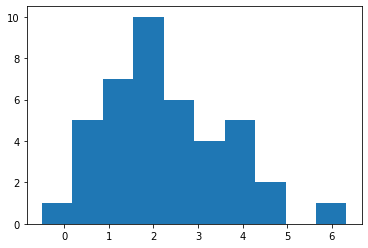

In [88]:
import matplotlib.pyplot as plt
plt.hist(df['revenues'])
plt.show()

In [89]:
from scipy.stats import t
from scipy.stats import norm
from scipy import stats

In [90]:
stat, p = shapiro(df['%_change'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.912, p=0.004
Probably not Gaussian


<AxesSubplot:>

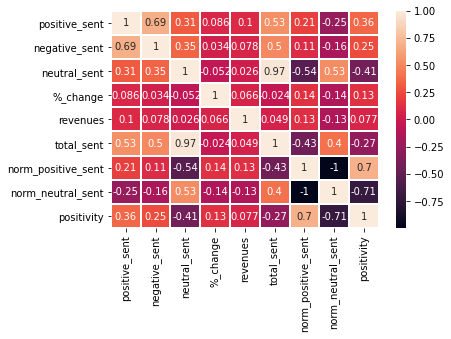

In [91]:
import seaborn as sns
sns.heatmap(df.corr(), annot = True, lw = 1)

In [102]:
X = df[['norm_positive_sent', 'negative_sent', 'revenues']]
y = df['%_change']
y = pd.to_numeric(y)

In [103]:
model = sm.OLS(y.astype(float), X.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               %_change   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):             -0.077
Method:                 Least Squares   F-statistic:                            0.02655
Date:                Thu, 11 Mar 2021   Prob (F-statistic):                       0.994
Time:                        02:37:52   Log-Likelihood:                         -96.948
No. Observations:                  41   AIC:                                      199.9
Df Residuals:                      38   BIC:                                      205.0
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
norm_positive_sent     0.3936      1.665      0.236      0.814      -2.977       3.764
negative_sent          0.1203      1.419      0.085      0.933      -2.751       2.992
revenues              -0.0670      0.255     -0.263      0.794      -0.584       0.450
==============================================================================
Omnibus:                       15.050   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               25.896
Skew:                          -0.920   Prob(JB):                     2.38e-06
Kurtosis:                       6.431   Cond. No.                         10.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
price_up = df[df['%_change']>0]
price_down = df[df['%_change']<=0]

In [105]:
p_value = stats.mannwhitneyu(price_up['norm_positive_sent'], price_down['norm_positive_sent'])
print(p_value)

MannwhitneyuResult(statistic=136.5, pvalue=0.02974676811408049)


In [106]:
p_value = stats.mannwhitneyu(price_up['norm_neutral_sent'], price_down['norm_neutral_sent'])
print(p_value)

MannwhitneyuResult(statistic=133.0, pvalue=0.024054956925836316)


Статистически значимые различия в тональности между двумя выборками (рост цены в день объявления СП 
                                                                     и отсутствие роста цены)

In [107]:
price_up['norm_positive_sent'].mean()

0.4143014415143602

In [108]:
price_down['norm_positive_sent'].mean()

0.28048832628225834

In [109]:
p_value = stats.mannwhitneyu(price_up['positivity'], price_down['positivity'])
print(p_value)

MannwhitneyuResult(statistic=154.5, pvalue=0.07876961582315084)
